Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


In [476]:
from keras.layers.normalization import BatchNormalization

The following functions are used to extract the time and day information from a timestamp value.

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [4]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing for ECO - Summer
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [2]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [3]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [4]:
df2 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_occupancy_csv/01_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

39

In [5]:
import datetime
summer = df2.index.tolist()
# for i in range(len(summer)):
#     item = pd.to_datetime(summer[i])
#     item = item.strftime('%Y%m%d')
#     summer[i] = item
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

39

In [25]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
#     data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
#                                             std1,std2,std3,std123,range1,range2,range3,range123,ptime)), 
#                             columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
#                                        'mean123','std1','std2','std3','std123',
#                                        'range1','range2','range3','range123','ptime'])
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

#         print(summer_features)
#        break

In [26]:
summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,24.541,67.500,9.315,132.982,103.091,129.301,71.862,244.994,57.775494,76.168270,...,0.974188,0.0,0.0,0.0,0.0,78.550,61.801,62.547,112.012,1.0
25,24.394,64.997,9.377,115.815,116.655,1411.660,72.407,1476.630,56.177676,244.087143,...,0.992230,0.0,0.0,0.0,0.0,92.261,1346.663,63.030,1360.815,2.0
26,24.440,34.284,9.181,68.577,25.195,1362.910,10.214,1397.610,24.790351,253.476867,...,0.980321,0.0,0.0,0.0,0.0,0.755,1328.626,1.033,1329.033,3.0
27,24.500,33.878,9.176,68.723,78.227,1324.660,10.851,1390.120,57.066767,93.425890,...,0.978886,0.0,0.0,0.0,0.0,53.727,1290.782,1.675,1321.397,4.0
28,24.379,33.719,9.243,67.799,62.065,34.772,10.128,106.200,45.192284,34.198749,...,0.998727,0.0,0.0,0.0,0.0,37.686,1.053,0.885,38.401,5.0
29,24.513,33.709,9.286,67.957,98.191,95.408,10.152,162.016,27.716543,35.430220,...,0.982954,0.0,0.0,0.0,0.0,73.678,61.699,0.866,94.059,6.0
30,55.175,33.588,9.219,98.626,57.584,119.937,10.305,187.091,56.220909,40.932154,...,0.992854,0.0,0.0,0.0,0.0,2.409,86.349,1.086,88.465,7.0
31,24.532,33.656,9.229,98.555,55.756,84.390,10.243,149.174,43.084998,74.511177,...,0.995619,0.0,0.0,0.0,0.0,31.224,50.734,1.014,50.619,8.0
32,24.728,76.543,8.918,111.544,91.713,803.033,10.219,838.116,29.132812,132.700551,...,0.755625,0.0,0.0,0.0,0.0,66.985,726.490,1.301,726.572,9.0
33,55.294,125.730,8.836,191.223,57.831,136.099,71.398,255.654,56.274994,129.458838,...,0.997407,0.0,0.0,0.0,0.0,2.537,10.369,62.562,64.431,10.0


In [27]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
# print(occ_summer_data)    
#     print(len(list_oc_summer))
#     if row[0] > '06:00:00':
#         print(row[1])
    

In [28]:
occ_summer_data

,occupancy
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [23]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [24]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Standardizing data
================

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(summer_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
summer_std = scaler.transform(summer_features)

In [54]:
summer_std[342,:]

array([-1.15468488, -0.94841829, -0.30307998, -1.10220057, -0.51630644,
       -0.61031616, -0.3323264 , -0.76222847, -0.51650922, -0.66318718,
       -0.32997961, -0.74829422, -0.37034645, -0.45667595, -0.23998985,
       -0.5340026 , -0.37923644, -0.3607771 , -0.12145553, -0.30669288,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.04195605, -0.04195605, -0.44813685, -0.53860912,
       -0.27007887, -0.65348456, -0.79950269])

In [52]:
summer_features.iloc[342]

min1        -1.0
min2        -1.0
min3        -1.0
min123      -1.0
max1        -1.0
max2        -1.0
max3        -1.0
max123      -1.0
mean1       -1.0
mean2       -1.0
mean3       -1.0
mean123     -1.0
std1         0.0
std2         0.0
std3         0.0
std123       0.0
sad1         0.0
sad2         0.0
sad3         0.0
sad123       0.0
corr1        NaN
corr2        NaN
corr3        NaN
corr123      NaN
onoff1       0.0
onoff2       0.0
onoff3       0.0
onoff123     0.0
range1       0.0
range2       0.0
range3       0.0
range123     0.0
ptime       18.0
Name: 41, dtype: float64

In [53]:
summer_std[np.isnan(summer_std)] = 0

PCA
====

In [344]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [345]:
pca.fit(summer_std)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [346]:
pca.n_components_

18

In [347]:
summer_pca = pca.transform(summer_std)

In [348]:
summer_pca.shape

(2535, 18)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [444]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_pca, occ_summer_data, test_size=0.3)

In [445]:
X_train.shape

(1774, 18)

Model Specification
-------------------------------
The following function is used to create the model.

In [446]:
def init_model():
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(17,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [447]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 18, 256)           1280      
_________________________________________________________________
dropout_175 (Dropout)        (None, 18, 256)           0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 18, 128)           131200    
_________________________________________________________________
dropout_176 (Dropout)        (None, 18, 128)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 18, 64)            32832     
_________________________________________________________________
dropout_177 (Dropout)        (None, 18, 64)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)              0         
__________

In [371]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 4
    for i in range(0,X.shape[0],4):
#         print(i)
        if  (i+4) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+4 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+4,:])
    res = np.array(res)
#     print(len(res))
    return res
   

Train on 1774 samples, validate on 761 samples
Epoch 1/200
1774/1774 [==============================] - 18s 10ms/step - loss: 0.5855 - acc: 0.7458 - val_loss: 0.4548 - val_acc: 0.8029
Epoch 2/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4972 - acc: 0.7723 - val_loss: 0.4174 - val_acc: 0.8016
Epoch 3/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4594 - acc: 0.7824 - val_loss: 0.3904 - val_acc: 0.7976
Epoch 4/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4412 - acc: 0.7875 - val_loss: 0.4048 - val_acc: 0.8108
Epoch 5/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4233 - acc: 0.8027 - val_loss: 0.3953 - val_acc: 0.7779
Epoch 6/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4398 - acc: 0.7931 - val_loss: 0.3770 - val_acc: 0.8081
Epoch 7/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.4215 - acc: 0.8044 - val_loss: 0.3741 - val_acc: 0.7989
Epoch 

Epoch 61/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.2931 - acc: 0.8613 - val_loss: 0.3677 - val_acc: 0.8279
Epoch 62/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.3038 - acc: 0.8546 - val_loss: 0.3664 - val_acc: 0.8187
Epoch 63/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.2978 - acc: 0.8534 - val_loss: 0.3641 - val_acc: 0.8305
Epoch 64/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.2869 - acc: 0.8574 - val_loss: 0.3872 - val_acc: 0.8292
Epoch 65/200
1774/1774 [==============================] - 3s 2ms/step - loss: 0.2832 - acc: 0.8630 - val_loss: 0.4094 - val_acc: 0.8331
Epoch 00065: early stopping
761/761 [==============================] - 0s 504us/step
[0.409366628617714, 0.8331143236504904]


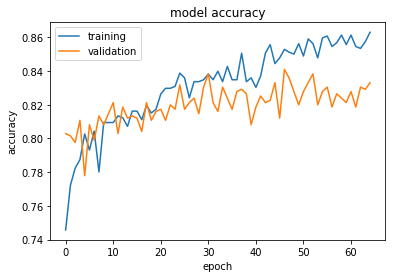

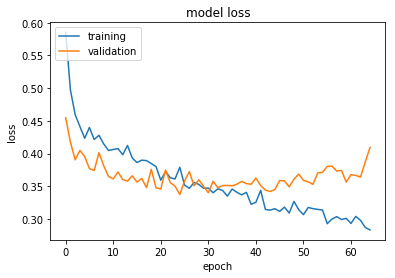

In [448]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
model = init_model()
# X_train = create_seq(X_train)
# y_train = create_seq(y_train.values)
# X_test = create_seq(X_test)
# y_test = create_seq(y_test.values)
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
history = model.fit(X_train, y_train, epochs=200, batch_size=32,validation_data=(X_test,y_test),callbacks=[es])
score = model.evaluate(X_test, y_test, batch_size=32)
print(score)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

(761, 1)


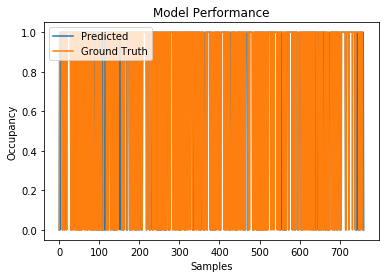

In [431]:
y_pred = model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print(y_test.shape)
samples = list(range(0,len(y_test)))
plt.plot(samples,y_test)
plt.plot(samples,y_pred)
plt.title('Model Performance')
plt.ylabel('Occupancy')
plt.xlabel('Samples')
plt.legend(['Predicted', 'Ground Truth'], loc='upper left')
plt.show()
# samples = []
# data_test = []
# data_pred = []
# for i in range(len(y_test)):
#     samples.extend(list(range(len(samples),len(samples)+len(y_test[i]))))
#     data_test.extend(y_test[i])
#     data_pred.extend(y_pred[i])
# plt.plot(samples,data_test,'-o', color='blue', linewidth=1, label = 'Ground Truth') 
# plt.plot(samples,data_pred,'-o', color='red', linewidth=1, label = 'Predicted') 
# plt.title('Model Performance')
# plt.legend(['Predicted', 'Ground Truth'], loc='upper left')
# plt.xlabel('Samples')
# plt.ylabel('Occupancy')
# plt.show()

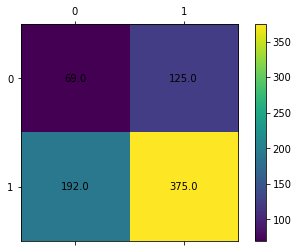

In [449]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


Data Preprocessing for ECO - Winter
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [2]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [3]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [451]:
df3 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_occupancy_csv/01_winter.csv",index_col=0)
df3.index = pd.to_datetime(df3.index)
df3.index = df3.index.strftime('%Y%m%d')
len(df3)

46

In [453]:
import datetime
winter = df3.index.tolist()
df_winter = {}
for key in df.keys():
    if key in winter:
        df_winter[key]=df[key]
len(df_winter)
#df_summer["20120730"]

46

In [454]:
n = 900  #chunk row size
winter_features = pd.DataFrame()
for day, data in df_winter.items():
    list_df_winter = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_winter:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
#     data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
#                                             std1,std2,std3,std123,range1,range2,range3,range123,ptime)), 
#                             columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
#                                        'mean123','std1','std2','std3','std123',
#                                        'range1','range2','range3','range123','ptime'])
    
    winter_features = winter_features.append(data)
winter_features.loc[winter_features.ptime < 25, 'ptime'] = 0
winter_features.loc[winter_features.ptime > 89, 'ptime'] = 0
winter_features = winter_features.loc[(winter_features['ptime'] >0)]
winter_features['ptime'] = winter_features['ptime'] - 24

#         print(summer_features)
#        break

In [455]:
winter_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,31.962,71.367,12.724,117.671,102.451,77.123,13.805,188.432,41.124103,73.951360,...,0.982764,0.0,0.0,0.0,0.0,70.489,5.756,1.081,70.761,1.0
25,61.260,29.305,12.830,103.697,63.140,71.952,14.078,148.094,62.019828,49.629829,...,0.998223,0.0,0.0,0.0,0.0,1.880,42.647,1.248,44.397,2.0
26,31.784,29.146,12.801,74.261,61.818,30.320,13.705,105.087,37.478154,29.718724,...,0.997046,0.0,0.0,0.0,0.0,30.034,1.174,0.904,30.826,3.0
27,31.834,29.286,12.767,74.312,85.537,732.210,711.126,1499.400,44.506607,117.657463,...,0.993711,0.0,0.0,0.0,0.0,53.703,702.924,698.359,1425.088,4.0
28,60.703,62.578,73.014,198.783,62.417,72.426,75.204,208.476,61.504024,69.406020,...,0.518571,0.0,0.0,0.0,0.0,1.714,9.848,2.190,9.693,5.0
29,31.514,67.193,15.231,115.266,61.210,72.769,190.010,291.888,33.517404,69.431001,...,0.990901,0.0,0.0,0.0,0.0,29.696,5.576,174.779,176.622,6.0
30,31.441,120.284,14.628,167.473,232.777,1432.170,71.235,1510.260,70.363117,405.803691,...,0.988963,0.0,0.0,0.0,0.0,201.336,1311.886,56.607,1342.787,7.0
31,31.628,272.136,14.638,319.613,62.321,1492.030,71.154,1569.290,60.562291,367.408303,...,0.978802,0.0,0.0,0.0,0.0,30.693,1219.894,56.516,1249.677,8.0
32,31.615,270.531,14.485,318.229,32.680,1592.100,15.494,1638.900,32.123178,435.213368,...,0.984372,0.0,0.0,0.0,0.0,1.065,1321.569,1.009,1320.671,9.0
33,31.702,186.246,14.667,263.580,87.886,304.316,15.623,405.440,49.470382,265.839304,...,0.997615,0.0,0.0,0.0,0.0,56.184,118.070,0.956,141.860,10.0


In [456]:
n = 900

cuml_list = []
for index,row in df3.iterrows():
    occ_winter = []
    list_oc_winter = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_winter:
        occ_winter.append(np.bincount(chunk).argmax())
    occ_winter = occ_winter[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_winter)
#     print(len(cuml_list))
occ_winter_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
# print(occ_summer_data)    
#     print(len(list_oc_summer))
#     if row[0] > '06:00:00':
#         print(row[1])
    

In [457]:
occ_winter_data

,occupancy
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [458]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [459]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Standardizing data
================

In [460]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(winter_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [461]:
winter_std = scaler.transform(winter_features)

In [462]:
winter_std[342,:]

array([-0.35469193, -0.07326352, -0.23766798, -0.35550361, -0.38924035,
       -0.42618719, -0.37293389, -0.61406222, -0.37087455, -0.27796289,
       -0.31653028, -0.498071  , -0.34168714, -0.33078197, -0.28051501,
       -0.49408254, -0.30610589, -0.26881155, -0.12056773, -0.27035956,
        0.29690128,  0.70352099, -1.42300046,  0.34641483,  0.        ,
        0.        , -0.0490899 , -0.04546831, -0.36602973, -0.43656579,
       -0.341651  , -0.59011481, -0.79950269])

In [463]:
winter_features.iloc[342]

min1         23.488000
min2         92.649000
min3         15.836000
min123      133.726000
max1        111.516000
max2        154.034000
max3         16.716000
max123      221.049000
mean1        35.566563
mean2       104.733858
mean3        16.275064
mean123     156.575486
std1         16.943266
std2         21.936193
std3          0.148010
std123       23.310534
sad1        405.538000
sad2        420.565000
sad3        157.865000
sad123      769.742000
corr1         0.979089
corr2         0.990257
corr3        -0.077010
corr123       0.980445
onoff1        0.000000
onoff2        0.000000
onoff3        0.000000
onoff123      0.000000
range1       88.028000
range2       61.385000
range3        0.880000
range123     87.323000
ptime        18.000000
Name: 41, dtype: float64

In [464]:
winter_std[np.isnan(winter_std)] = 0

PCA
====

In [466]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [467]:
pca.fit(winter_std)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [468]:
pca.n_components_

17

In [469]:
winter_pca = pca.transform(winter_std)

In [470]:
winter_pca.shape

(2990, 17)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [477]:
from sklearn.model_selection import train_test_split
X_trainw, X_testw, y_trainw, y_testw = train_test_split(winter_pca, occ_winter_data, test_size=0.15)

In [478]:
X_trainw.shape

(2541, 17)

Model Specification
-------------------------------
The following function is used to create the model.

In [479]:
def init_model2():
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(17,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [480]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 18, 256)           1280      
_________________________________________________________________
dropout_181 (Dropout)        (None, 18, 256)           0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 18, 128)           131200    
_________________________________________________________________
dropout_182 (Dropout)        (None, 18, 128)           0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 18, 64)            32832     
_________________________________________________________________
dropout_183 (Dropout)        (None, 18, 64)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
__________

In [371]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 4
    for i in range(0,X.shape[0],4):
#         print(i)
        if  (i+4) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+4 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+4,:])
    res = np.array(res)
#     print(len(res))
    return res
   

Train on 2541 samples, validate on 449 samples
Epoch 1/200
2541/2541 [==============================] - 51s 20ms/step - loss: 0.5668 - acc: 0.7355 - val_loss: 0.4583 - val_acc: 0.8330
Epoch 2/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.4298 - acc: 0.8257 - val_loss: 0.4057 - val_acc: 0.8396
Epoch 3/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.4034 - acc: 0.8308 - val_loss: 0.3311 - val_acc: 0.8597
Epoch 4/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.3676 - acc: 0.8485 - val_loss: 0.3440 - val_acc: 0.8463
Epoch 5/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.3677 - acc: 0.8363 - val_loss: 0.3451 - val_acc: 0.8552
Epoch 6/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.3526 - acc: 0.8579 - val_loss: 0.3018 - val_acc: 0.8641
Epoch 7/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.3309 - acc: 0.8477 - val_loss: 0.3100 - val_acc: 0.8686
Epoch 

Epoch 61/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2397 - acc: 0.8910 - val_loss: 0.2871 - val_acc: 0.8909
Epoch 62/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2412 - acc: 0.8894 - val_loss: 0.2733 - val_acc: 0.8753
Epoch 63/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2417 - acc: 0.8941 - val_loss: 0.2732 - val_acc: 0.8886
Epoch 64/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2321 - acc: 0.8953 - val_loss: 0.2870 - val_acc: 0.8686
Epoch 65/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2349 - acc: 0.8902 - val_loss: 0.2644 - val_acc: 0.8775
Epoch 66/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2342 - acc: 0.8977 - val_loss: 0.2787 - val_acc: 0.8753
Epoch 67/200
2541/2541 [==============================] - 8s 3ms/step - loss: 0.2395 - acc: 0.8827 - val_loss: 0.2745 - val_acc: 0.8753
Epoch 68/200
2541/2541 [========================

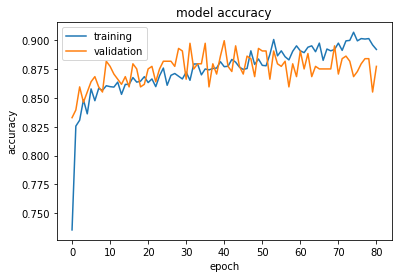

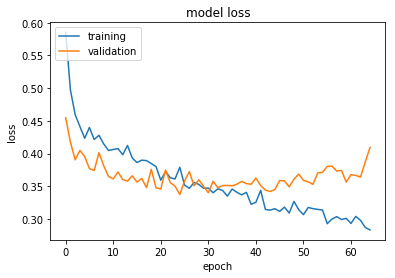

In [481]:
X_trainw = X_trainw.reshape(X_trainw.shape[0], X_trainw.shape[1],1)
X_testw = X_testw.reshape(X_testw.shape[0], X_testw.shape[1],1)
modelw = init_model2()
# X_train = create_seq(X_train)
# y_train = create_seq(y_train.values)
# X_test = create_seq(X_test)
# y_test = create_seq(y_test.values)
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
historyw = modelw.fit(X_trainw, y_trainw, epochs=200, batch_size=32,validation_data=(X_testw,y_testw),callbacks=[es])
scorew = modelw.evaluate(X_testw, y_testw, batch_size=32)
print(scorew)
plt.plot(historyw.history['acc'])
plt.plot(historyw.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

(761, 1)


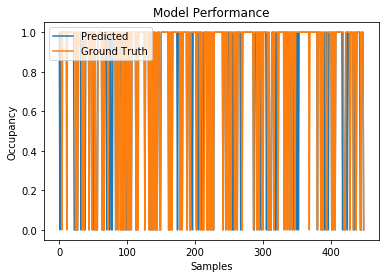

In [482]:
y_predw = modelw.predict(X_testw)
y_predw[y_predw > 0.5] = 1
y_predw[y_predw <= 0.5] = 0
print(y_test.shape)
samples = list(range(0,len(y_testw)))
plt.plot(samples,y_testw)
plt.plot(samples,y_predw)
plt.title('Model Performance')
plt.ylabel('Occupancy')
plt.xlabel('Samples')
plt.legend(['Predicted', 'Ground Truth'], loc='upper left')
plt.show()
# samples = []
# data_test = []
# data_pred = []
# for i in range(len(y_test)):
#     samples.extend(list(range(len(samples),len(samples)+len(y_test[i]))))
#     data_test.extend(y_test[i])
#     data_pred.extend(y_pred[i])
# plt.plot(samples,data_test,'-o', color='blue', linewidth=1, label = 'Ground Truth') 
# plt.plot(samples,data_pred,'-o', color='red', linewidth=1, label = 'Predicted') 
# plt.title('Model Performance')
# plt.legend(['Predicted', 'Ground Truth'], loc='upper left')
# plt.xlabel('Samples')
# plt.ylabel('Occupancy')
# plt.show()

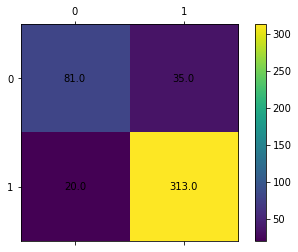

In [483]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cmw = confusion_matrix(y_testw, y_predw)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmw)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


K-fold Cross Validation
=====================

In [484]:
from sklearn.model_selection import StratifiedKFold

In [495]:
Xw=winter_pca
yw=occ_winter_data.values

In [498]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for trainw, testw in kfold.split(Xw, yw):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_trainw = Xw[trainw].reshape(winter_pca[trainw].shape[0], Xw[trainw].shape[1],1)
    X_testw = Xw[testw].reshape(Xw[testw].shape[0], Xw[testw].shape[1],1)
    modelw = init_model2()
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    historyw = modelw.fit(X_trainw, yw[trainw], epochs=200, batch_size=32,validation_data=(X_testw,yw[testw]),callbacks=[es])
    scorew = modelw.evaluate(X_testw, yw[testw], batch_size=32)
    plt.plot(historyw.history['acc'])
    plt.plot(historyw.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scorew[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scorew[0]))
    y_predw = modelw.predict(X_testw)
    y_predw[y_predw > 0.5] = 1
    y_predw[y_predw <= 0.5] = 0
    cmw = confusion_matrix(yw[testw], y_predw)
    cvscores.append(scorew[1] * 100)
    cvsloss.append(scorew[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Train on 2562 samples, validate on 428 samples
Epoch 1/200
2562/2562 [==============================] - 26s 10ms/step - loss: 0.5592 - acc: 0.7389 - val_loss: 0.4824 - val_acc: 0.8318
Epoch 2/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.4443 - acc: 0.8189 - val_loss: 0.4493 - val_acc: 0.8364
Epoch 3/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.3924 - acc: 0.8419 - val_loss: 0.3626 - val_acc: 0.8551
Epoch 4/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.3723 - acc: 0.8376 - val_loss: 0.3444 - val_acc: 0.8551
Epoch 5/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.3591 - acc: 0.8486 - val_loss: 0.3320 - val_acc: 0.8692
Epoch 6/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.3376 - acc: 0.8501 - val_loss: 0.3308 - val_acc: 0.8598
Epoch 7/200
2562/2562 [==============================] - 8s 3ms/step - loss: 0.3473 - acc: 0.8450 - val_loss: 0.3233 - val_acc: 0.8692
Epoch 

KeyboardInterrupt: 